In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import re
import string
import requests
import matplotlib.pyplot as plt

### Step 1: Dataset Loading and Preprocessing

In [4]:
url = "https://www.gutenberg.org/files/100/100-0.txt"
response = requests.get(url)
text = response.text

In [18]:
# print(text)

### Text Preprocessing

In [9]:
def preprocess_text(text):
    text = text.lower()  # lowercase
    
    text = re.sub(r'\s+', ' ', text) # Remove extra space
    
    text = re.sub(r'[^a-zA-Z\s.,!?;:\-\']', '', text)
    
    text = text.strip()
    return text


In [ ]:
# Preprocess the text
clean_text = preprocess_text(text)

In [17]:
print(clean_text[:2000])

start of the project gutenberg ebook   the complete works of william shakespeare by william shakespeare contents the sonnets alls well that ends well the tragedy of antony and cleopatra as you like it the comedy of errors the tragedy of coriolanus cymbeline the tragedy of hamlet, prince of denmark the first part of king henry the fourth the second part of king henry the fourth the life of king henry the fifth the first part of henry the sixth the second part of king henry the sixth the third part of king henry the sixth king henry the eighth the life and death of king john the tragedy of julius caesar the tragedy of king lear loves labours lost the tragedy of macbeth measure for measure the merchant of venice the merry wives of windsor a midsummer nights dream much ado about nothing the tragedy of othello, the moor of venice pericles, prince of tyre king richard the second king richard the third the tragedy of romeo and juliet the taming of the shrew the tempest the life of timon of at

### Create Character-Level Sequences

In [19]:
# Create character-to-index and index-to-character mappings
chars = sorted(list(set(clean_text)))
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

vocab_size = len(chars)
print(vocab_size)
print(chars)

35
[' ', '!', "'", ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Prepare Training Data

In [20]:
def create_sequences(text, seq_length=40):
    sequences = []
    targets = []
    
    for i in range(len(text) - seq_length):
        seq = text[i:i + seq_length]
        target = text[i + seq_length]
        
        sequences.append(seq)
        targets.append(target)
    
    return sequences, targets

# Create sequences
SEQ_LENGTH = 40
sequences, targets = create_sequences(clean_text, SEQ_LENGTH)

print(sequences[0])
print(targets[0])

start of the project gutenberg ebook   t
h


### Convert to Numerical Data

In [21]:
X = np.zeros((len(sequences), SEQ_LENGTH), dtype=np.int32)
y = np.zeros((len(sequences), vocab_size), dtype=np.int32)

for i, (seq, target) in enumerate(zip(sequences, targets)):
    for j, char in enumerate(seq):
        X[i, j] = char_to_idx[char]
    
    y[i, char_to_idx[target]] = 1

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (5245711, 40)
y shape: (5245711, 35)


### Train-Validation Split

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape[0])
print(X_val.shape[0])

4196568
1049143


### Step 2: Model Design

In [26]:
def build_lstm_model(vocab_size, seq_length, embedding_dim=50, lstm_units=128):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=seq_length),
        LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), # First Layer
        LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2), # Second Layer
        Dense(vocab_size // 2, activation='relu'), # Dense layer
        Dropout(0.5),
        Dense(vocab_size, activation='softmax') # Output layer
    ])
    
    return model

In [27]:
# Build model
model = build_lstm_model(vocab_size, SEQ_LENGTH)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\VINAY PATEL\anaconda3\envs\env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Step 3: Model Training

In [31]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=1,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

4099/4099 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.3250 - loss: 2.3325

4099/4099 ━━━━━━━━━━━━━━━━━━━━ 2338s 570ms/step - accuracy: 0.3250 - loss: 2.3325 - val_accuracy: 0.4322 - val_loss: 1.8865


### Plot Training History

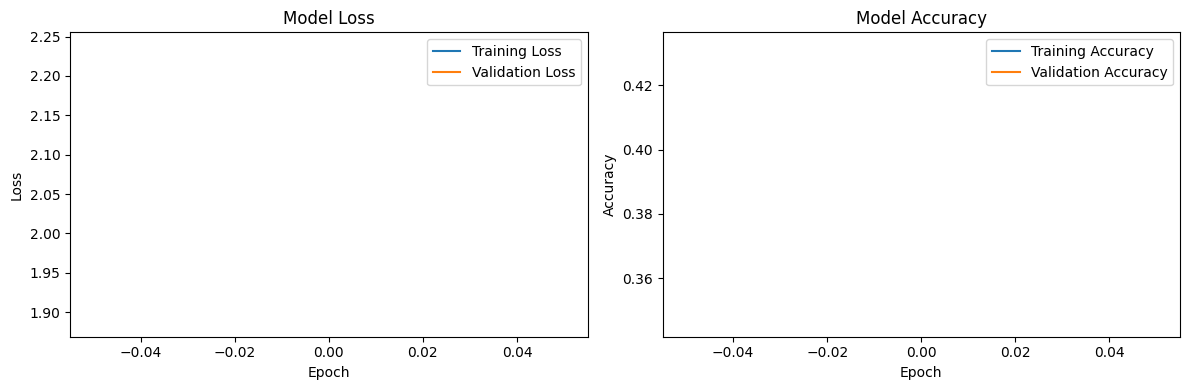

In [32]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Step 4: Text Generation

In [33]:
def generate_text(model, seed_text, num_chars=500, temperature=1.0):
    seed_text = preprocess_text(seed_text.lower())
    if len(seed_text) < SEQ_LENGTH:
        seed_text = ' ' * (SEQ_LENGTH - len(seed_text)) + seed_text
    
    seed_text = seed_text[-SEQ_LENGTH:]
    
    generated_text = seed_text
    
    for _ in range(num_chars):
        x_pred = np.zeros((1, SEQ_LENGTH))
        for i, char in enumerate(seed_text):
            if char in char_to_idx:
                x_pred[0, i] = char_to_idx[char]
        
        # Predict next character
        predictions = model.predict(x_pred, verbose=0)[0]
        predictions = np.log(predictions + 1e-8) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        
        next_idx = np.random.choice(len(predictions), p=predictions)
        next_char = idx_to_char[next_idx]
        
        generated_text += next_char
        seed_text = seed_text[1:] + next_char
    
    return generated_text

seed_texts = [
    "To be or not to be",
    "Romeo and Juliet",
    "The king is dead",
    "Love is"
]

print("=" * 80)
print("GENERATED TEXT SAMPLES")
print("=" * 80)

for seed in seed_texts:
    print(f"\nSeed: '{seed}'")
    print("-" * 40)
    
    for temp in [0.5, 1.0, 1.5]:
        print(f"\nTemperature {temp}:")
        generated = generate_text(model, seed, num_chars=300, temperature=temp)
        clean_generated = generated[len(seed):].strip()
        print(clean_generated)
        print()

GENERATED TEXT SAMPLES

Seed: 'To be or not to be'
----------------------------------------

Temperature 0.5:
to be or not to be ear the mease in apbeet the the so of me sates of everer whither do worth whot of conton the legh would the none entor saar me the worther that and the stors to nalr to he the thing this wind made and he of i the enter, and to is the wate hither on no that more me horse goid lood he the admens at t


Temperature 1.0:
to be or not to be on as od kemps i dothevess, blowsled ditder, of him fake hit lebles ansicparva be you jesullenn. feim cui cotsit to ni-anomaunirinkef-yew hyfant erisn rattre. malse? she parrome alrorm romey moor, vanlomaw and daeth sich echand. hinglirt hath ebaxbap unsiy, dictlees fiinbent! prolouras this laid in


Temperature 1.5:
to be or not to be. engirulh higkcois olseave emitieqosibtys; rather. hair a sweokty a tulsnoty qouo your verhovicy speatcilk wipd fapvolt his oy; me oullechiel, kint aks; peclrarlifrd. qlurh dosg! for thee nosaree

### Step 5: Model Evaluation and Analysis

In [34]:
def evaluate_model():
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    return val_loss, val_accuracy

# Evaluate the model
print("Model Performance:")
evaluate_model()

Model Performance:
Validation Loss: 1.8865
Validation Accuracy: 0.4322


(1.8864976167678833, 0.432244211435318)

### Bonus: Experiment with Different Architectures

In [35]:
def build_deeper_model(vocab_size, seq_length):
    model = Sequential([
        Embedding(vocab_size, 64, input_length=seq_length),
        
        LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        LSTM(128, dropout=0.3, recurrent_dropout=0.3),
        
        Dense(vocab_size * 2, activation='relu'),
        Dropout(0.5),
        Dense(vocab_size, activation='softmax')
    ])
    
    return model


In [36]:
deeper_model = build_deeper_model(vocab_size, SEQ_LENGTH)
deeper_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Deeper Model Architecture:")
deeper_model.summary()

Deeper Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### End